##### Copyright 2020 The TensorFlow Authors.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Train and serve a TensorFlow model with TensorFlow Serving


**Warning: This notebook is designed to be run in a Google Colab only**.  It installs packages on the system and requires root access.  If you want to run it in a local Jupyter notebook, please proceed with caution.

Note: You can run this example right now in a Jupyter-style notebook, no setup required!  Just click "Run in Google Colab"

<div class="devsite-table-wrapper"><table class="tfo-notebook-buttons" align="left">
<tr><td><a target="_blank" href="https://www.tensorflow.org/tfx/tutorials/serving/rest_simple">
<img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a></td>
<td><a target="_blank" href="https://colab.research.google.com/github/tensorflow/tfx/blob/master/docs/tutorials/serving/rest_simple.ipynb">
<img src="https://www.tensorflow.org/images/colab_logo_32px.png">Run in Google Colab</a></td>
<td><a target="_blank" href="https://github.com/tensorflow/tfx/blob/master/docs/tutorials/serving/rest_simple.ipynb">
<img width=32px src="https://www.tensorflow.org/images/GitHub-Mark-32px.png">View source on GitHub</a></td>
<td><a href="https://storage.googleapis.com/tensorflow_docs/tfx/docs/tutorials/serving/rest_simple.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a></td>
</tr></table></div>

This guide trains a neural network model to classify [images of clothing, like sneakers and shirts](https://github.com/zalandoresearch/fashion-mnist), saves the trained model, and then serves it with [TensorFlow Serving](https://www.tensorflow.org/tfx/guide/serving).  The focus is on TensorFlow Serving, rather than the modeling and training in TensorFlow, so for a complete example which focuses on the modeling and training see the [Basic Classification example](https://github.com/tensorflow/docs/blob/master/site/en/r1/tutorials/keras/basic_classification.ipynb).

This guide uses [tf.keras](https://github.com/tensorflow/docs/blob/master/site/en/r1/guide/keras.ipynb), a high-level API to build and train models in TensorFlow.

In [1]:
from google.colab import drive
drive.mount('/content/GDrive')

Mounted at /content/GDrive


In [2]:
import sys
import platform
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import random
import matplotlib.pyplot as plt
import os
import subprocess

import tempfile
import json
import requests

In [3]:
# Confirm that we're using Python 3
assert sys.version_info.major == 3, 'Oops, not running Python 3. Use Runtime > Change runtime type'

In [ ]:
sys.modules

sys.module: \
This module provides access to some variables used or maintained by the interpreter and to functions that interact strongly with the interpreter. It is always available.

In [4]:
# We need sudo prefix if not on a Google Colab.
if 'google.colab' not in sys.modules:
  SUDO_IF_NEEDED = 'sudo'
else:
  SUDO_IF_NEEDED = ''

print("SUDO_IF_NEEDED=", SUDO_IF_NEEDED)

SUDO_IF_NEEDED= 


In [6]:
# TensorFlow and tf.keras
print("Installing dependencies for Colab environment")
!pip install grpcio

Installing dependencies for Colab environment
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [7]:
# docs_infra: no_execute
!pip install -q requests

net-tools: \
* ifconfig
* arp
* ipmaddr
* route
* nameif
* mii-tool

In [8]:
!apt-get install net-tools

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following NEW packages will be installed:
  net-tools
0 upgraded, 1 newly installed, 0 to remove and 23 not upgraded.
Need to get 196 kB of archives.
After this operation, 864 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu focal/main amd64 net-tools amd64 1.60+git20180626.aebd88e-1ubuntu1 [196 kB]
Fetched 196 kB in 1s (150 kB/s)
Selecting previously unselected package net-tools.
(Reading database ... 128285 files and directories currently installed.)
Preparing to unpack .../net-tools_1.60+git20180626.aebd88e-1ubuntu1_amd64.deb ...
Unpacking net-tools (1.60+git20180626.aebd88e-1ubuntu1) ...
Setting up net-tools (1.60+git20180626.aebd88e-1ubuntu1) ...
Processing triggers for man-db (2.9.1-1) ...


In [9]:
platform.platform()

'Linux-5.10.147+-x86_64-with-glibc2.31'

[GLIBC](https://ko.wikipedia.org/wiki/Glibc)

In [10]:
!ldd --version

ldd (Ubuntu GLIBC 2.31-0ubuntu9.9) 2.31
Copyright (C) 2020 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.
Written by Roland McGrath and Ulrich Drepper.


In [11]:
!ldd `which git`

	linux-vdso.so.1 (0x00007ffe13b7a000)
	libpcre2-8.so.0 => /lib/x86_64-linux-gnu/libpcre2-8.so.0 (0x00007fbb9ac36000)
	libz.so.1 => /lib/x86_64-linux-gnu/libz.so.1 (0x00007fbb9ac1a000)
	libpthread.so.0 => /lib/x86_64-linux-gnu/libpthread.so.0 (0x00007fbb9abf7000)
	libc.so.6 => /lib/x86_64-linux-gnu/libc.so.6 (0x00007fbb9aa05000)
	/lib64/ld-linux-x86-64.so.2 (0x00007fbb9b01f000)


In [12]:
print('TensorFlow version: {}'.format(tf.__version__))

TensorFlow version: 2.11.0


In [13]:
import os
import pathlib

if "models" in pathlib.Path.cwd().parts:
  while "models" in pathlib.Path.cwd().parts:
    os.chdir('..')
elif not pathlib.Path('models').exists():
  !git clone https://github.com/tensorflow/models

Cloning into 'models'...
remote: Enumerating objects: 82502, done.
remote: Counting objects: 100% (408/408), done.
remote: Compressing objects: 100% (182/182), done.
remote: Total 82502 (delta 254), reused 354 (delta 226), pack-reused 82094
Receiving objects: 100% (82502/82502), 596.53 MiB | 17.89 MiB/s, done.
Resolving deltas: 100% (58894/58894), done.


In [ ]:
%%bash
sudo apt install -y protobuf-compiler
cd /content/models/research/
protoc object_detection/protos/*.proto --python_out=.
# cd /content
# git clone https://github.com/cocodataset/cocoapi.git
# cd /content/cocoapi/PythonAPI
# make
# cp -r pycocotools /content/models/research/
# cd /content/models/research/
cp object_detection/packages/tf2/setup.py .
python -m pip install .
cd /content

In [ ]:
!python /content/models/research/object_detection/builders/model_builder_tf2_test.py

In [16]:
!pwd

/content


mkdir -p option : 만약 부모 디렉토리가 존재하지 않는다면, 부모 디렉토리까지 생성

In [17]:
!mkdir -p obj_detection/1

In [18]:
!wget http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_mobilenet_v1_fpn_640x640_coco17_tpu-8.tar.gz

--2023-03-23 06:29:14--  http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_mobilenet_v1_fpn_640x640_coco17_tpu-8.tar.gz
Resolving download.tensorflow.org (download.tensorflow.org)... 74.125.130.128, 2404:6800:4003:c01::80
Connecting to download.tensorflow.org (download.tensorflow.org)|74.125.130.128|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 90453990 (86M) [application/x-tar]
Saving to: ‘ssd_mobilenet_v1_fpn_640x640_coco17_tpu-8.tar.gz’

ssd_mobilenet_v1_fp 100%[===================>]  86.26M  51.1MB/s    in 1.7s    

2023-03-23 06:29:16 (51.1 MB/s) - ‘ssd_mobilenet_v1_fpn_640x640_coco17_tpu-8.tar.gz’ saved [90453990/90453990]



In [19]:
!cp "/content/GDrive/MyDrive/TF_OD_API/ssd_mobilenet_v2/saved_model.pb" \
/content/obj_detection/1

In [20]:
!cp -r "/content/GDrive/MyDrive/TF_OD_API/ssd_mobilenet_v2/variables" \
/content/obj_detection/1

In [21]:
!pwd

/content


In [22]:
export_path = "/content/obj_detection/1"

In [23]:
!saved_model_cli show --dir {export_path} --all

2023-03-23 06:44:46.747232: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib64-nvidia
2023-03-23 06:44:46.747473: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib64-nvidia
2023-03-23 06:44:46.747518: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.

MetaGraphDef with tag-set: 'serve' contains the following SignatureDefs:

signature_def['__saved_model_init_op']:
  The given SavedModel SignatureDef contains the fol

In [24]:
MODEL_DIR = "/content/obj_detection"
print("MODEL_DIR=", MODEL_DIR)

MODEL_DIR= /content/obj_detection


In [25]:
version = 1
export_path = os.path.join(MODEL_DIR, str(version))
print('export_path = {}\n'.format(export_path))
print("export_path=", export_path)

export_path = /content/obj_detection/1

export_path= /content/obj_detection/1


In [26]:
!ls -la {export_path}

total 8684
drwxr-xr-x 3 root root    4096 Mar 23 06:44 .
drwxr-xr-x 3 root root    4096 Mar 23 06:28 ..
-rw------- 1 root root 8876207 Mar 23 06:44 saved_model.pb
drwx------ 2 root root    4096 Mar 23 06:44 variables


## Examine your saved model

We'll use the command line utility `saved_model_cli` to look at the [MetaGraphDefs](https://www.tensorflow.org/versions/r1.15/api_docs/python/tf/MetaGraphDef) (the models) and [SignatureDefs](../signature_defs) (the methods you can call) in our SavedModel.  See [this discussion of the SavedModel CLI](https://github.com/tensorflow/docs/blob/master/site/en/r1/guide/saved_model.md#cli-to-inspect-and-execute-savedmodel) in the TensorFlow Guide.

[dpkg](https://ko.wikipedia.org/wiki/Dpkg)

In [27]:
!wget 'http://storage.googleapis.com/tensorflow-serving-apt/pool/tensorflow-model-server-universal-2.8.0/t/tensorflow-model-server-universal/tensorflow-model-server-universal_2.8.0_all.deb'
!dpkg -i tensorflow-model-server-universal_2.8.0_all.deb

--2023-03-23 06:49:33--  http://storage.googleapis.com/tensorflow-serving-apt/pool/tensorflow-model-server-universal-2.8.0/t/tensorflow-model-server-universal/tensorflow-model-server-universal_2.8.0_all.deb
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.200.128, 74.125.68.128, 74.125.24.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.200.128|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 335421916 (320M) [application/x-debian-package]
Saving to: ‘tensorflow-model-server-universal_2.8.0_all.deb’

tensorflow-model-se 100%[===================>] 319.88M  16.9MB/s    in 20s     

2023-03-23 06:49:54 (15.8 MB/s) - ‘tensorflow-model-server-universal_2.8.0_all.deb’ saved [335421916/335421916]

Selecting previously unselected package tensorflow-model-server-universal.
(Reading database ... 128334 files and directories currently installed.)
Preparing to unpack tensorflow-model-server-universal_2.8.0_all.deb ...
Unpackin

### Install TensorFlow Serving

This is all you need - one command line!

In [ ]:
# !{SUDO_IF_NEEDED} apt-get install tensorflow-model-server

### Start running TensorFlow Serving

This is where we start running TensorFlow Serving and load our model.  After it loads we can start making inference requests using REST.  There are some important parameters:

* `rest_api_port`: The port that you'll use for REST requests.
* `model_name`: You'll use this in the URL of REST requests.  It can be anything.
* `model_base_path`: This is the path to the directory where you've saved your model.


In [28]:
print(MODEL_DIR)

/content/obj_detection


In [ ]:
!cp sss ddd

In [31]:
!echo $PATH

/opt/bin:/usr/local/nvidia/bin:/usr/local/cuda/bin:/usr/local/sbin:/usr/local/bin:/usr/sbin:/usr/bin:/sbin:/bin:/tools/node/bin:/tools/google-cloud-sdk/bin


In [32]:
!which ls

/usr/bin/ls


In [30]:
!which cp

/usr/bin/cp


In [33]:
os.environ["MODEL_DIR"] = MODEL_DIR

In [34]:
!echo $MODEL_DIR

/content/obj_detection


In [35]:
MODEL="ssd_mobilenet_v2"

linux \
* STDIN(standard input) : 0
* STDOUT(standard output) : 1
* STDERR(standard error) : 2
* & : 앞의 명령어를 백그라운드로 실행시키고 동시에 뒤의 명령어를 실행

In [36]:
%%bash --bg 
nohup tensorflow_model_server \
  --rest_api_port=8501 \
  --model_name=ssd_mobilenet_v2 \
  --model_base_path="${MODEL_DIR}" >server.log 2>&1


#### bg
해당 프로세스를 foreground가 아닌 background 작업으로 실행시키는 명령

#### nohup

리눅스, 유닉스에서 쉘스크립트파일 (*.sh)을 데몬형태로 실행시키는 프로그램

터미널 세션이 끊겨도 실행을 멈추지 않고 동작하도록 함

In [37]:
!ps -A

    PID TTY          TIME CMD
      1 ?        00:00:00 docker-init
      7 ?        00:00:07 node
     17 ?        00:00:02 oom_monitor.sh
     19 ?        00:00:00 run.sh
     20 ?        00:00:01 kernel_manager_
     37 ?        00:00:00 tail
     54 ?        00:00:04 python3 <defunct>
     55 ?        00:00:02 colab-fileshim.
     90 ?        00:00:08 jupyter-noteboo
     91 ?        00:00:05 dap_multiplexer
    190 ?        00:00:23 python3
    233 ?        00:00:11 python3
    490 ?        00:00:00 bash
    491 ?        00:00:00 drive
    492 ?        00:00:00 grep
    611 ?        00:00:03 drive
    710 ?        00:00:00 bash
    711 ?        00:00:00 directoryprefet
    712 ?        00:00:00 tail
    713 ?        00:00:00 python3
   8216 ?        00:01:19 node
  23649 ?        00:00:00 bash
  23651 ?        00:00:03 tensorflow_mode
  23711 ?        00:00:00 sleep
  23712 ?        00:00:00 ps


In [38]:
!netstat -tnlp

Active Internet connections (only servers)
Proto Recv-Q Send-Q Local Address           Foreign Address         State       PID/Program name    
tcp        0      0 0.0.0.0:8500            0.0.0.0:*               LISTEN      23651/tensorflow_mo 
tcp        0      0 0.0.0.0:8501            0.0.0.0:*               LISTEN      23651/tensorflow_mo 
tcp        0      0 127.0.0.1:54649         0.0.0.0:*               LISTEN      233/python3         
tcp        0      0 0.0.0.0:3453            0.0.0.0:*               LISTEN      55/python3          
tcp        0      0 172.28.0.12:9000        0.0.0.0:*               LISTEN      90/python3          
tcp        0      0 127.0.0.1:23502         0.0.0.0:*               LISTEN      233/python3         
tcp        0      0 172.28.0.12:6000        0.0.0.0:*               LISTEN      20/kernel_manager_p 
tcp        0      0 127.0.0.1:44051         0.0.0.0:*               LISTEN      190/python3         
tcp        0      0 127.0.0.11:46771        0.0.

In [39]:
!tail server.log

[warn] getaddrinfo: address family for nodename not supported
[evhttp_server.cc : 245] NET_LOG: Entering the event loop ...


In [ ]:
# !tail server.log

[warn] getaddrinfo: address family for nodename not supported
[evhttp_server.cc : 245] NET_LOG: Entering the event loop ...


## Make a request to your model in TensorFlow Serving

First, let's take a look at a random example from our test data.

Ok, that looks interesting.  How hard is that for you to recognize? Now let's create the JSON object for a batch of  three inference requests, and see how well our model recognizes things:

In [40]:
import numpy as np
from PIL import Image

In [41]:
def load_image_into_numpy_array(path):
    """Load an image from file into a numpy array.

    Puts image into numpy array to feed into tensorflow graph.
    Note that by convention we put it into a numpy array with shape
    (height, width, channels), where channels=3 for RGB.

    Args:
      path: the file path to the image

    Returns:
      uint8 numpy array with shape (img_height, img_width, 3)
    """
    return np.array(Image.open(path))

In [42]:
!mkdir inferimages

In [43]:
IMAGES_PATH="/content/inferimages"

In [44]:
PROTOCOL = 'rest'

In [45]:
SERVER_URL = 'http://localhost:8501/v1/models/{}:predict'.format(MODEL)
print(SERVER_URL)

http://localhost:8501/v1/models/ssd_mobilenet_v2:predict


In [46]:
def get_random_image(image_dir):
    image_path = os.path.join(image_dir, random.choice(os.listdir(image_dir)))
    print("test image:", image_path)
    image = Image.open(image_path)
    (im_width, im_height) = image.size

    return np.array(image.getdata()).reshape((im_height, im_width, 3)).astype(np.uint8)

In [ ]:
# def get_random_image(image_dir):
#     image_path = os.path.join(image_dir, random.choice(os.listdir(image_dir)))
#     print("test image:", image_path)
#     image = Image.open(image_path)
#     (im_width, im_height) = image.size

#     return np.array(image.getdata()).reshape((im_height, im_width, 3)).astype(np.uint8)

In [47]:
def make_request(batch_size):   
    image_path = os.path.join(IMAGES_PATH, random.choice(os.listdir(IMAGES_PATH))) 
    np_images = np.repeat(np.expand_dims(get_random_image(IMAGES_PATH), 0).tolist(), batch_size, axis=0)
    print("*"*60)
    print(np_images.shape)
    return (image_path, np_images)

In [ ]:
# def make_request(batch_size):    
#     image_path, a = get_random_image(IMAGES_PATH)
 
#     print(image_path)
    
#     np_images = np.repeat(np.expand_dims(a.tolist(), batch_size, axis=0))
#     print("*"*60)
#     print(np_images.shape)
#     return image_path, np_images

In [48]:
header = {"content-type": "application/json"}

In [49]:
def send_request(predict_request):
    response = requests.post(SERVER_URL, data=predict_request, headers=header) 

    return response

In [50]:
import time

In [63]:
def benchmark(batch_size=1, num_iteration=20, warm_up_iteration=10):
    
    total_time = 0
    
    image_path, predict_request = make_request(batch_size)
    print("predict_request", type(predict_request))
    data = json.dumps({"signature_name": "serving_default", "instances": predict_request.tolist()})
    print('Data: {} ... {}'.format(data[:50], data[len(data)-52:]))
    start_time = time.time()
    
    response = send_request(data)     
    print(response)   
    
    predictions = json.loads(response.text)['predictions']
    
    
    return (image_path , predictions)
        # if i > warm_up_iteration:
        #     total_time += time_consume

    # time_average = total_time / (num_iteration - warm_up_iteration)
    # print('Average time: %.3f sec' % (time_average))
    # print('Batch size = %d' % batch_size)
    # if batch_size == 1:
    #     print('Latency: %.3f ms' % (time_average * 1000))
    # print('Throughput: %.3f images/sec' % (batch_size / time_average))

In [69]:
!ls -al /content/inferimages/

total 516
drwxr-xr-x 2 root root   4096 Mar 23 08:10 .
drwxr-xr-x 1 root root   4096 Mar 23 08:09 ..
-rw-r--r-- 1 root root 516516 Mar 23 08:08 jumbo1.jpg


In [68]:
!rm -r /content/inferimages/.ipynb_checkpoints

In [70]:
current_target_image_path, predictions = benchmark(batch_size=1, num_iteration=1, warm_up_iteration=10)

test image: /content/inferimages/jumbo1.jpg
************************************************************
(1, 699, 1052, 3)
predict_request <class 'numpy.ndarray'>
Data: {"signature_name": "serving_default", "instances": ... 119, 117, 105], [119, 115, 104], [126, 122, 111]]]]}
<Response [200]>


In [48]:
print(current_target_image_path)

/content/inferimages/cake1.jpg


In [71]:
image_np = load_image_into_numpy_array(current_target_image_path)

In [54]:
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as viz_utils
%matplotlib inline

In [55]:
category_index = label_map_util.create_category_index_from_labelmap("/content/GDrive/MyDrive/TF_OD_API/ssd_mobilenet_v2/mscoco_label_map.pbtxt",use_display_name=True)

In [72]:
def load_image_into_numpy_array(path):
    """Load an image from file into a numpy array.

    Puts image into numpy array to feed into tensorflow graph.
    Note that by convention we put it into a numpy array with shape
    (height, width, channels), where channels=3 for RGB.

    Args:
      path: the file path to the image

    Returns:
      uint8 numpy array with shape (img_height, img_width, 3)
    """
    return np.array(Image.open(path))

In [58]:
def changetoInt(l, dtype=int):
    return list(map(dtype, l))

In [73]:
detections = predictions[0]

num_detections = int(detections['num_detections'])
detections['num_detections'] = num_detections

detections['detection_boxes'] = np.array(detections['detection_boxes'])

detections['detection_classes'] = changetoInt(detections['detection_classes'])
detections['detection_classes'] = np.array(detections['detection_classes'])

detections['detection_scores'] = np.array(detections['detection_scores'])

Done


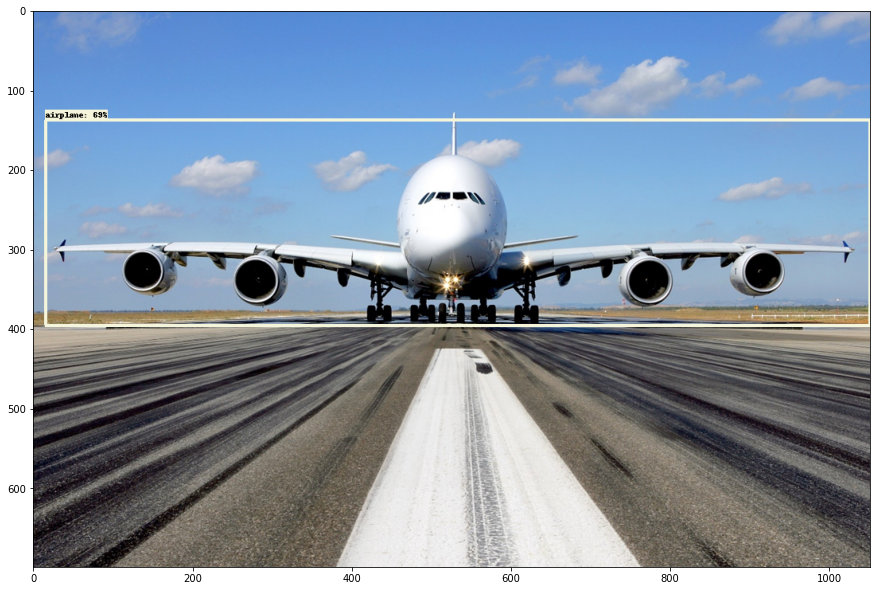

In [74]:
image_np_with_detections = image_np.copy()

viz_utils.visualize_boxes_and_labels_on_image_array(
      image_np_with_detections,
      detections['detection_boxes'],
      detections['detection_classes'],
      detections['detection_scores'],
      category_index,
      use_normalized_coordinates=True,
      max_boxes_to_draw=100,
      min_score_thresh=.50,
      agnostic_mode=False)

plt.figure(figsize=(15,15))
plt.imshow(image_np_with_detections)
print('Done')
plt.show()

In [57]:
!tail server.log

[warn] getaddrinfo: address family for nodename not supported
[evhttp_server.cc : 245] NET_LOG: Entering the event loop ...


#### A particular version of the servable

Now let's specify a particular version of our servable.  Since we only have one, let's select version 1.  We'll also look at all three results.